# Redox Couple - Experimental

In [1]:
from pymultieis.multieis import *

ModuleNotFoundError: No module named 'torchmin.optim'

In [ ]:
#|hide
import numpy as np
import pandas as pd
import scipy.sparse as sps
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.facecolor'] = 'white'

In this example we fit a series of admittance data obtained from an experimental redox system. The weighting will be the standard deviation. The first step is always to load the data.

In [ ]:
F_redox_exp = torch.tensor(np.load('../../../data/redox_exp_50/freq_50.npy'), dtype=torch.float64)
Y_redox_exp = torch.tensor(np.load('../../../data/redox_exp_50/Y_50.npy'))
Yerr_redox_exp = torch.tensor(np.load('../../../data/redox_exp_50/sigma_Y_50.npy'))

The next step is to define the model which could be an equivalent circuit model or some other function that returns the complex immitance. Here we used a modified randles circuit.

In [ ]:
def redox_exp(p, f):
    w = 2*torch.pi*f
    s = 1j * w
    Rs = p[0]
    Qh = p[1]
    nh = p[2]
    Rct = p[3]
    Wct = p[4]
    Rw = p[5]
    Zw = 1/(1/(Wct/torch.sqrt(w) * (1-1j)) + 1/Rw)
    Z = Rs + ((s**nh)*Qh + 1/(Rct+Zw))**-1
    Y = 1/Z
    return torch.cat((Y.real, Y.imag), dim = 0)


Next we define the initial guess, the bounds, and the smoothing factor. When the standard deviation of the immittance data is available, it is advisable to set the smoothing to a high value, run the fit and recreate an instance using the returned fit parameters as initial guess and a smoothing factor one-tenth the original value. This procedure should be repeated until the change in the reduced chisquare becomes lower than or equal to 0.1 or until the smoothing factor is decreased to 1.0. This is illustrated in `Example 3.0`

However, when the modulus or some other weighting is used, setting the smoothing factor to 1.0 should be sufficient. In this example we set the smoothing factor to 100000.

In [ ]:
p0_redox_exp = torch.tensor([3000, 1.3799e-06, 0.75, 4000, 1e5, 5e5], dtype=torch.float64)

bounds_redox_exp = [[1e-15,1e15], [1e-8, 1e2], [1e-1,1e0], [1e-15,1e15], [1e-15,1e15], [1e-15,1e15]]

smf_redox_exp = torch.tensor([100000, 100000, 100000, 100000, 100000, 100000])

Now we instantiate the `Multieis` class with the respective arguments.

In [ ]:
eis_redox_exp = Multieis(p0_redox_exp, F_redox_exp, Y_redox_exp, bounds_redox_exp, smf_redox_exp, redox_exp, weight=Yerr_redox_exp, immittance='admittance')

We can view certain attributes of the Multieis instance we just created

In [ ]:
eis_redox_exp.p0.shape # Shape of the initial guess

torch.Size([6])

In [ ]:
eis_redox_exp.weight_name # Weight mode selected

'sigma'

In [ ]:
eis_redox_exp.immittance # Immittance type being fitted

'admittance'

Next we call the fit_deterministic method with the default parameters

In [ ]:
popt_redox_exp, perr_redox_exp, chisqr_redox_exp, chitot_redox_exp, AIC_redox_exp = eis_redox_exp.fit_deterministic2(n_iter = 7000)

Iteration : 1000, Loss : 2.91112e+01
Iteration : 2000, Loss : 2.58077e+01
Iteration : 2267, Loss : 2.57451e+01
Optimization complete
total time is 0:00:12.357368 

We can view the the popt, perr of 25th spectra in the series:

In [ ]:
print(popt_redox_exp[:, 25])

tensor([1.6230e+02, 2.9070e-08, 9.3126e-01, 6.4987e+03, 1.2838e+05, 4.9098e+05])


In [ ]:
print(perr_redox_exp[:, 25])

tensor([9.5185e-01, 1.7956e-10, 6.3025e-03, 3.5715e+01, 8.4552e+02, 3.7683e+03])


We can also examine the chisquare and AIC

In [ ]:
print(chisqr_redox_exp, AIC_redox_exp)

25.00764 -361.47583


Next we examine the resulting Nyquist, Bode and paremeter plots

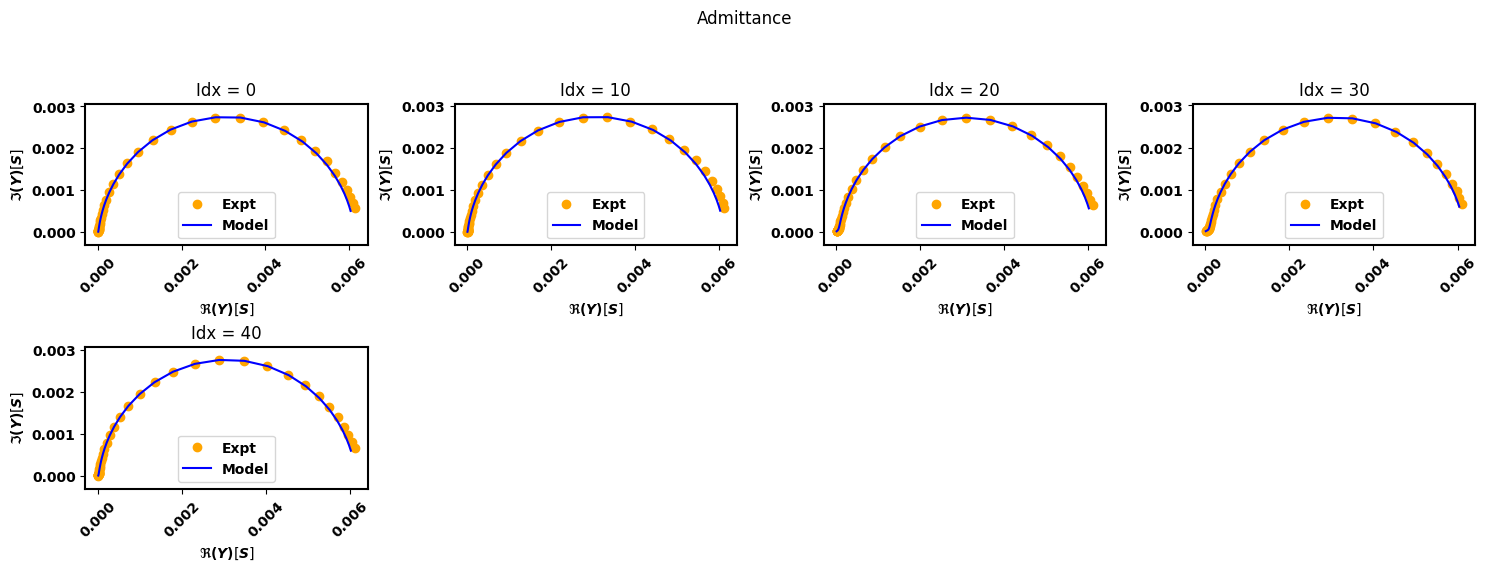

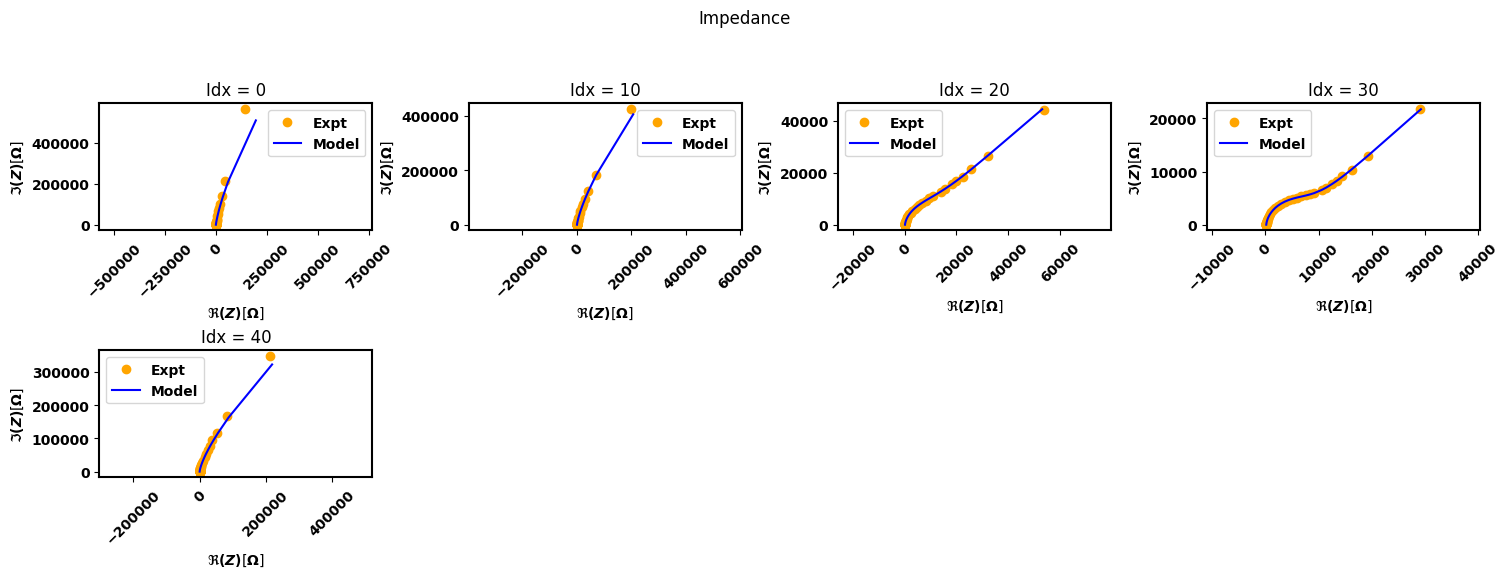

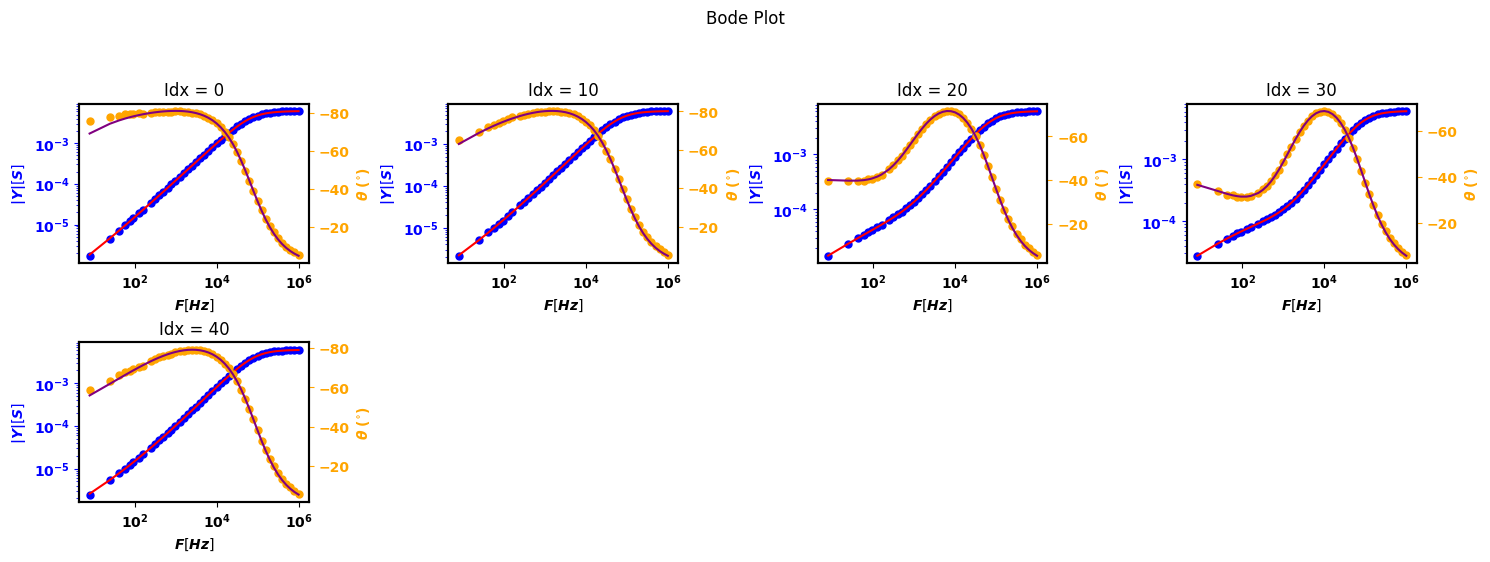

In [ ]:
eis_redox_exp.plot_nyquist(steps = 10)
eis_redox_exp.plot_bode(steps = 10)

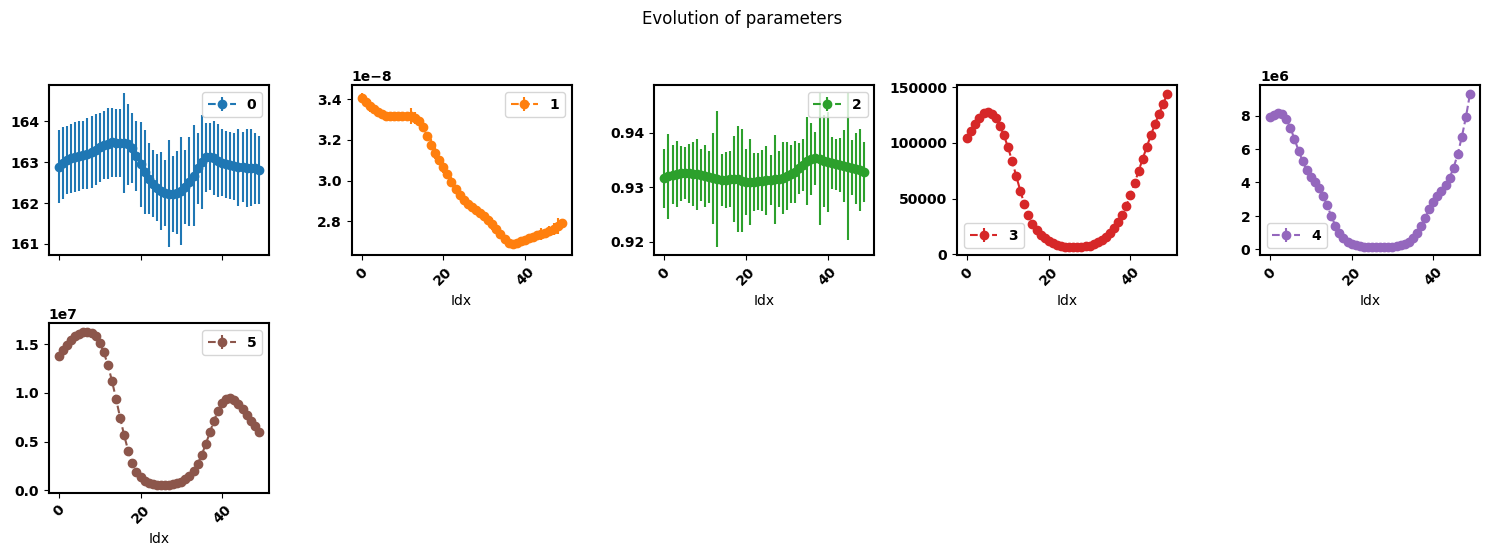

In [ ]:
eis_redox_exp.plot_params(show_errorbar = True)

We could also run a bootstrap with 500 terations and re-plot the results

In [ ]:
perrmc_redox_exp = eis_redox_exp.compute_perr_mc(n_boots = 5)

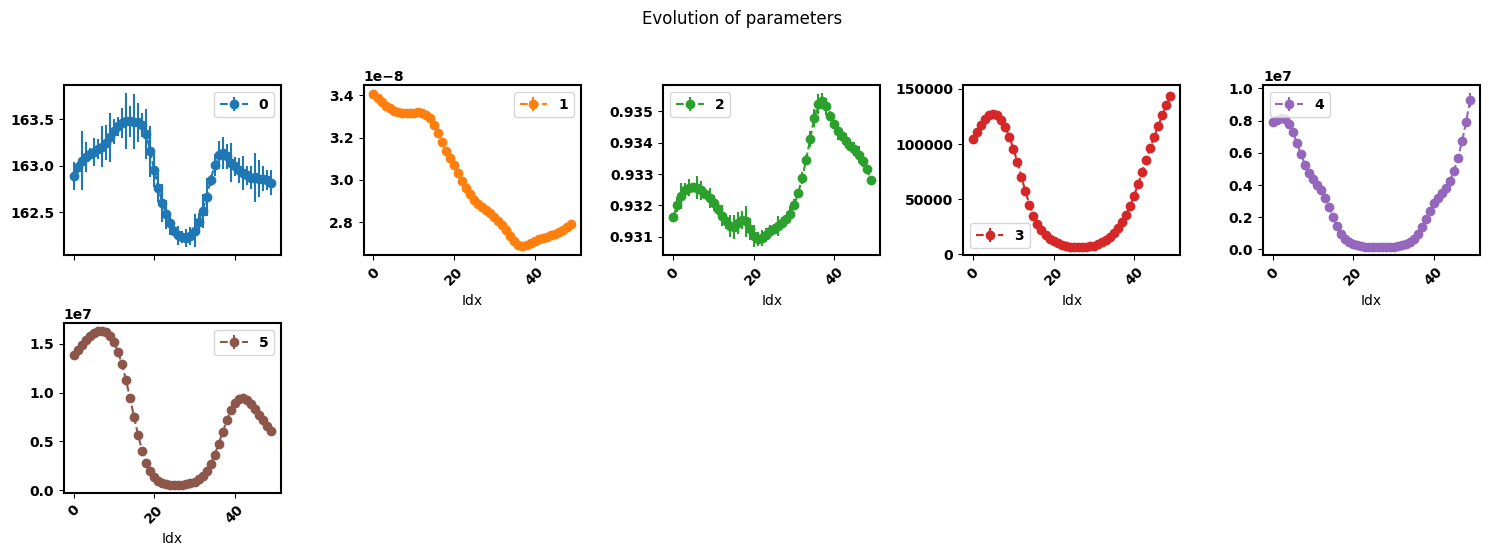

In [ ]:
eis_redox_exp.plot_params(show_errorbar = True)